# Research Question 2 - sentiment, ratings and box office  

This notebook does the ground work for answering the two subquestions related to research question 2 (stated in the ReadME). The problem and subquestions we aim at adressing are:      
    
    Sentiment analysis in quotes about movies over time. Additionaly relate sentiment to Box Office sales and see if positive/negative media coverage affect the sale of tickets.    
    
    - RQ2.1: Does the media/quoters opinion on a certain movie affect the amount of sold tickets?     
    - RQ2.2: Does the sentiment seen in quotes relate to the rating on IMDB? 
    
Conclusions will be drawn here and also used in the `milestone3` file in the main directory of the repo.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import plotly.express as px
import plotly
import re

### Load Box Office, IMDb and Quotebank

We start by loading the three regarded data sets from their respective pickles / csv-files that are investigated in the exploratory notebooks. We choose to load the Quotebank data with associated sentiment scores as it will be relevant to adress this RQ.

In [2]:
data_dir = os.getcwd() + os.sep + f'exploratory{os.sep}data'

# load pickled data
df_Quotebank = pd.read_pickle(rf"{data_dir}{os.sep}Quotebank_sentiment.pkl") 
df_boxOffice = pd.read_pickle(rf"{data_dir}{os.sep}boxOffice.pkl")   

# load IMDb csv-files and merge
movies = pd.read_csv(rf"{data_dir}{os.sep}IMDb{os.sep}IMDB movies.csv", low_memory=False)
ratings = pd.read_csv(rf"{data_dir}{os.sep}IMDb{os.sep}IMDB ratings.csv")    
df_imdb = movies.merge(ratings, on='imdb_title_id')


We check that these were correctly loaded by looking at the head of the dataframes.

In [3]:
df_Quotebank.head(3)

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,AFINN_score,VADER_label,VADER_score,BERT_label,BERT_score,positive_BERT_score,scaledReverted_BERT_score
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751,POSITIVE,0.500000,POSITIVE,0.3612,NEGATIVE,0.989802,0.010198,-0.541032
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724,POSITIVE,0.165563,POSITIVE,0.9910,POSITIVE,0.999293,0.999293,0.787788
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692,NEGATIVE,-0.153846,NEGATIVE,-0.6369,NEGATIVE,0.833872,0.166128,-0.208302


In [4]:
df_boxOffice.head()

,days,dow,rank,daily,theaters,special events,movie
0,2019-05-24,Friday,1,31358935.0,4476,NaN,Aladdin
1,2019-05-25,Saturday,1,30013295.0,4476,NaN,Aladdin
2,2019-05-26,Sunday,1,30128699.0,4476,NaN,Aladdin
3,2019-05-27,Monday,1,25305033.0,4476,Memorial Day,Aladdin
4,2019-05-28,Tuesday,1,12014982.0,4476,NaN,Aladdin


In [5]:
df_imdb.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0


In [6]:
overlap = np.intersect1d(df_imdb.original_title.unique(), df_Quotebank.movie.unique())
print(overlap)
print(f"\nsize of overlap of movie titles: {overlap.__len__()}")

['Aladdin' 'Aquaman' 'Avengers: Age of Ultron' 'Avengers: Endgame'
 'Avengers: Infinity War' 'Bad Boys for Life'
 'Batman v Superman: Dawn of Justice' 'Beauty and the Beast'
 'Birds of Prey: And the Fantabulous Emancipation of One Harley Quinn'
 'Black Panther' 'Bohemian Rhapsody' 'Captain America: Civil War'
 'Captain Marvel' 'Deadpool' 'Deadpool 2' 'Despicable Me 3' 'Dolittle'
 'Fantastic Beasts and Where to Find Them'
 'Fantastic Beasts: The Crimes of Grindelwald' 'Fast & Furious 7'
 'Finding Dory' 'Frozen II' 'Guardians of the Galaxy Vol. 2'
 'Incredibles 2' 'Inside Out' 'Joker' 'Jumanji: The Next Level'
 'Jumanji: Welcome to the Jungle' 'Jurassic World'
 'Jurassic World: Fallen Kingdom' 'Minions'
 'Mission: Impossible - Fallout' 'Mission: Impossible - Rogue Nation'
 'Onward' 'Rogue One' 'Sonic the Hedgehog' 'Spectre'
 'Spider-Man: Far from Home' 'Spider-Man: Homecoming'
 'Star Wars: Episode IX - The Rise of Skywalker'
 'Star Wars: Episode VII - The Force Awakens'
 'Star Wars: Epis

We only make use of the movies that we restricted ourselves to in the Quotebank data. This is done below.

In [7]:
# choose movies
df_imdb = df_imdb[np.isin(df_imdb.original_title, overlap)]

# choose years
Quotebank_years = pd.Series([date.split("-")[0] for date in df_Quotebank.date.unique()]).unique()
df_imdb = df_imdb[np.isin(df_imdb.year, Quotebank_years)]

# update indeces
df_imdb.index = np.arange(len(df_imdb))

In [8]:
print(f"Shape of dataframe: {df_imdb.shape}")
df_imdb.head()

Shape of dataframe: (58, 70)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0
2,tt1051906,L'uomo invisibile,The Invisible Man,2020,2020-03-27,"Horror, Mystery, Sci-Fi",124,"Canada, Australia, USA",English,Leigh Whannell,...,7.1,6778.0,7.2,1603.0,6.9,373.0,7.2,15568.0,7.0,49787.0
3,tt1270797,Venom,Venom,2018,2018-10-04,"Action, Adventure, Sci-Fi",112,"China, USA","English, Mandarin, Malay",Ruben Fleischer,...,7.0,14589.0,7.2,3063.0,6.3,556.0,6.6,35509.0,6.6,125428.0
4,tt1386697,Suicide Squad,Suicide Squad,2016,2016-08-13,"Action, Adventure, Fantasy",123,USA,"English, Japanese, Spanish",David Ayer,...,6.2,27359.0,6.4,4816.0,5.7,740.0,5.9,60869.0,5.9,203451.0


We are only supposed to have 56 movies in the frame. Let's find out which ones are duplicated.

In [9]:
movies, freq = np.unique(df_imdb.original_title, return_counts=True)
movies[freq > 1]

array(['Joker', 'The Invisible Man'], dtype=object)

Let's investigate these and see which duplicate is the false one. Then we outfilter these ones.

In [10]:
df_imdb[df_imdb.original_title == 'Joker']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
47,tt5611648,Joker,Joker,2016,2016-08-12,"Comedy, Drama",130,India,Tamil,"Raju Murugan, Raju Saravanan",...,8.1,22.0,8.0,2.0,6.6,19.0,8.1,171.0,8.2,870.0
54,tt7286456,Joker,Joker,2019,2019-10-03,"Crime, Drama, Thriller",122,"USA, Canada",English,Todd Phillips,...,8.4,35220.0,8.3,7620.0,7.9,630.0,8.2,77947.0,8.4,281183.0


In [11]:
df_imdb[df_imdb.original_title == 'The Invisible Man']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
2,tt1051906,L'uomo invisibile,The Invisible Man,2020,2020-03-27,"Horror, Mystery, Sci-Fi",124,"Canada, Australia, USA",English,Leigh Whannell,...,7.1,6778.0,7.2,1603.0,6.9,373.0,7.2,15568.0,7.0,49787.0
55,tt7651078,The Invisible Man,The Invisible Man,2017,2018-02-04,Sci-Fi,88,USA,English,"Khian Bartlett, Carol Damgen",...,4.7,6.0,4.0,7.0,4.0,10.0,3.5,57.0,3.2,35.0


The rows to be removed are 47 and 55 - this can also be seen by the number of votes on the IMDb ratings.

In [12]:
df_imdb = df_imdb.drop([47, 55])
df_imdb.index = np.arange(len(df_imdb))
print(f"Shape of dataframe: {df_imdb.shape}")

Shape of dataframe: (56, 70)


In [13]:
df_imdb

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0
2,tt1051906,L'uomo invisibile,The Invisible Man,2020,2020-03-27,"Horror, Mystery, Sci-Fi",124,"Canada, Australia, USA",English,Leigh Whannell,...,7.1,6778.0,7.2,1603.0,6.9,373.0,7.2,15568.0,7.0,49787.0
3,tt1270797,Venom,Venom,2018,2018-10-04,"Action, Adventure, Sci-Fi",112,"China, USA","English, Mandarin, Malay",Ruben Fleischer,...,7.0,14589.0,7.2,3063.0,6.3,556.0,6.6,35509.0,6.6,125428.0
4,tt1386697,Suicide Squad,Suicide Squad,2016,2016-08-13,"Action, Adventure, Fantasy",123,USA,"English, Japanese, Spanish",David Ayer,...,6.2,27359.0,6.4,4816.0,5.7,740.0,5.9,60869.0,5.9,203451.0
5,tt1431045,Deadpool,Deadpool,2016,2016-02-18,"Action, Adventure, Comedy",108,USA,English,Tim Miller,...,7.9,41239.0,7.9,7845.0,7.5,804.0,8.1,91566.0,7.8,309504.0
6,tt1477834,Aquaman,Aquaman,2018,2019-01-01,"Action, Adventure, Fantasy",143,"USA, Australia","English, Russian, Maori, Italian",James Wan,...,6.9,16691.0,7.1,4411.0,6.6,594.0,6.9,38872.0,6.8,121047.0
7,tt1502397,Bad Boys for Life,Bad Boys for Life,2020,2020-02-20,"Action, Comedy, Crime",124,"USA, Mexico","English, Spanish","Adil El Arbi, Bilall Fallah",...,6.8,4338.0,6.8,1149.0,6.1,315.0,6.7,12297.0,6.5,42309.0
8,tt1727824,Bohemian Rhapsody,Bohemian Rhapsody,2018,2018-11-29,"Biography, Drama, Music",134,"UK, USA","English, British Sign Language",Bryan Singer,...,8.3,29897.0,8.6,9605.0,7.2,609.0,7.8,45282.0,7.9,161478.0
9,tt1825683,Black Panther,Black Panther,2018,2018-02-14,"Action, Adventure, Sci-Fi",134,USA,"English, Swahili, Nama, Xhosa, Korean",Ryan Coogler,...,7.6,28085.0,7.8,7494.0,6.8,679.0,7.6,78364.0,7.0,196556.0


### Restricting ourselves to the use-case

We start by cutting down the dataframe to its essence that is related to research question. Other than the descriptive information about the movies, we need ratings from users, critics and eventually the distribution of votes across specific ratings. We might want to analyse the description of the movie too. Here are the attributes we keep so far (we might extend the selection later):

`original_title` is the movie title agreeing with the Quotebank data.''

`genre` is the movie genre.

`year` is the year.

`date_published` is the release date of the movie.

`description` is a description about the movie. 

`metascore` is a rating of the film based on the world's most respective critics (weighted average). Possible maximum is 100. 

`weighted_average_vote` is the score IMDb weighted average rating. This is what appears on the IMDb webpage and is based on users votes. Possible maximum is 10.

`votes` is the total number of votes.

`votes_[1-10]` is number of votes with the specific rating.


In [14]:
votes_n = [f"votes_{n}" for n in range(1,11)]
votes_n

['votes_1',
 'votes_2',
 'votes_3',
 'votes_4',
 'votes_5',
 'votes_6',
 'votes_7',
 'votes_8',
 'votes_9',
 'votes_10']

In [15]:
# attributes of interest
aoi = np.union1d(votes_n, ['original_title', 'genre', 'year', 'date_published', 'description', 'metascore', 'weighted_average_vote']).tolist()

print("Attributes to keep:")
aoi

Attributes to keep:


['date_published',
 'description',
 'genre',
 'metascore',
 'original_title',
 'votes_1',
 'votes_10',
 'votes_2',
 'votes_3',
 'votes_4',
 'votes_5',
 'votes_6',
 'votes_7',
 'votes_8',
 'votes_9',
 'weighted_average_vote',
 'year']

In [16]:
df_imdb = df_imdb[aoi].set_index('original_title')
df_imdb.head()

,date_published,description,genre,metascore,votes_1,votes_10,votes_2,votes_3,votes_4,votes_5,votes_6,votes_7,votes_8,votes_9,weighted_average_vote,year
original_title,,,,,,,,,,,,,,,,
Jurassic World,2015-06-11,"A new theme park, built on the original site o...","Action, Adventure, Sci-Fi",59.0,6535,51492,5015,8511,17147,40501,94206,168772,126084,51249,7.0,2015
Wonder Woman,2017-06-01,When a pilot crashes and tells of conflict in ...,"Action, Adventure, Fantasy",76.0,10173,77571,4129,6184,11009,24811,58393,123602,140814,79217,7.4,2017
The Invisible Man,2020-03-27,When Cecilia's abusive ex takes his own life a...,"Horror, Mystery, Sci-Fi",72.0,2101,7863,1074,1732,3040,7405,19223,41258,34089,12020,7.1,2020
Venom,2018-10-04,A failed reporter is bonded to an alien entity...,"Action, Adventure, Sci-Fi",35.0,4681,36096,3719,7151,13249,29043,63473,97505,63947,24744,6.7,2018
Suicide Squad,2016-08-13,A secret government agency recruits some of th...,"Action, Adventure, Fantasy",40.0,23814,52301,18294,28084,45219,78385,120917,120338,69754,29368,6.0,2016


### RQ2.1: Does the media/quoters opinion on a certain movie affect the amount of sold tickets?

Box office related to sentiment

In [90]:
# attributes of interest in boxOffice
boxOffice_aoi = ['days', 'dow', 'daily', 'movie']

# create basis for combined dataframe with Quotebank sentiment
df_combined = df_boxOffice[boxOffice_aoi].set_index(['movie', 'days']).sort_values('days')
df_combined

dow       daily
movie            days                             
Fast & Furious 7 2015-04-03     Friday  67407340.0
                 2015-04-04   Saturday  46626580.0
                 2015-04-05     Sunday  33153120.0
                 2015-04-06     Monday  14015350.0
                 2015-04-07    Tuesday  13311640.0
...                                ...         ...
Tenet            2021-04-11     Sunday       684.0
                 2021-04-12     Monday       342.0
                 2021-04-13    Tuesday       356.0
                 2021-04-14  Wednesday       467.0
                 2021-04-15   Thursday       637.0

[6905 rows x 2 columns]

In [91]:
# rename for consistency between data sets
df_Quotebank = df_Quotebank.rename(columns={'date': 'days'})

# attributes of interest in Quotebank
Quotebank_aoi = ['quotation', 'days', 'movie', 'shared_ID', 'positive_BERT_score', 'BERT_label']
daily_sent_movie = df_Quotebank[Quotebank_aoi].groupby(by=['movie', 'days']).positive_BERT_score.mean()

# add daily sentiment to boxOffice data
df_combined['daily_sent_movie'] = daily_sent_movie

In [92]:
df_combined

dow       daily  daily_sent_movie
movie            days                                               
Fast & Furious 7 2015-04-03     Friday  67407340.0          0.929640
                 2015-04-04   Saturday  46626580.0          0.998048
                 2015-04-05     Sunday  33153120.0          0.995893
                 2015-04-06     Monday  14015350.0               NaN
                 2015-04-07    Tuesday  13311640.0          0.999187
...                                ...         ...               ...
Tenet            2021-04-11     Sunday       684.0               NaN
                 2021-04-12     Monday       342.0               NaN
                 2021-04-13    Tuesday       356.0               NaN
                 2021-04-14  Wednesday       467.0               NaN
                 2021-04-15   Thursday       637.0               NaN

[6905 rows x 3 columns]

In [114]:
temp = df_combined.groupby(by='days').mean()
temp = temp.reset_index(['days'])
temp 

,days,daily,daily_sent_movie
0,2015-04-03,67407340.0,0.929640
1,2015-04-04,46626580.0,0.998048
2,2015-04-05,33153120.0,0.995893
3,2015-04-06,14015350.0,NaN
4,2015-04-07,13311640.0,0.999187
...,...,...,...
2033,2021-04-11,684.0,NaN
2034,2021-04-12,342.0,NaN
2035,2021-04-13,356.0,NaN
2036,2021-04-14,467.0,NaN


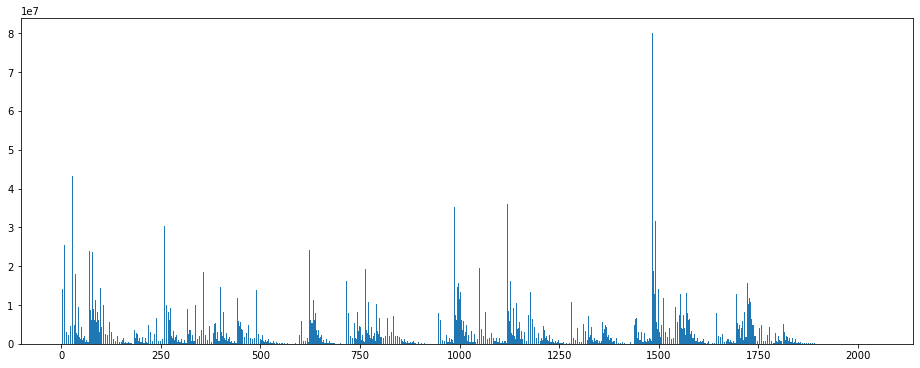

In [119]:
plt.figure(figsize=((16,6)))
plt.bar(np.arange(len(temp.days)), temp.daily)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
df_imdb.reviews_from_critics + df_imdb.reviews_from_users

In [ ]:
df_imdb.weighted_average_vote.describe()

In [ ]:
# transformer
from transformers import pipeline
classifier = pipeline("sentiment-analysis")

In [ ]:
sent_description = pd.Series([classifier(description) for description in tqdm(df_imdb['description'])])